In [1]:
import os
import pandas as pd
import janitor
import numpy as np


dfs = {}

ruta = os.path.join('..', 'data')

years = range(2019, 2024)

for year in years:
    file_path = os.path.join(ruta, f'{year}clean.csv')  # crea la ruta al archivo
    dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario

df2019 = dfs['df2019']
df2020 = dfs['df2020']
df2021 = dfs['df2021']
df2022 = dfs['df2022']
df2023 = dfs['df2023']
df2019['año']=2019
df2020['año']=2020
df2021['año']=2021
df2022['año']=2022
df2023['año']=2023

for name, df in dfs.items():
    dfs[name] = df.clean_names()


/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_31357/387917906.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_31357/387917906.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_31357/387917906.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_31357/387917906.py:15: DtypeWarning: Columns (6,20,42,43) have mixed

In [2]:
# Crear una lista de dataframes
dfs_list = [dfs[name] for name in dfs.keys()]

# Concatenar todos los dataframes
contratos_df = pd.concat(dfs_list, ignore_index=True)

contratos_df.rename(columns={'ano':'año'}, inplace = True)

In [3]:
from currency_converter import CurrencyConverter


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'object':
        contratos_df[column] = contratos_df[column].str.upper()


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'string':
        contratos_df[column] = contratos_df[column].str.upper()

c = CurrencyConverter()
currencies=['USD', 'CAD', 'EUR', 'GBP', 'JPY']

# Create a dictionary to store conversion rates
conversion_rates = {}

for m in currencies:
    conversion_rate = c.convert(1, m, 'MXN')
    print(1, m, "=", conversion_rate, 'MXN')
    conversion_rates[m] = conversion_rate

# Apply conversion rates
contratos_df["importe"] = contratos_df["importe_del_contrato"]

for currency, conversion_rate in conversion_rates.items():
    contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , 'importe'] = contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , "importe_del_contrato"] * conversion_rate

print('Done')


1 USD = 17.115130976369297 MXN
1 CAD = 13.018183084854396 MXN
1 EUR = 18.6863 MXN
1 GBP = 21.75912340762477 MXN
1 JPY = 0.11946998273767662 MXN
Done


In [4]:

def correct_swap(df):
    # Define un patrón de RFC válido
    rfc_pattern = r"^[A-ZÑ&]{3,4}[0-9]{2}(0[1-9]|1[0-2])(0[1-9]|1[0-9]|2[0-9]|3[0-1])[A-Z0-9]?[A-Z0-9]?[0-9A]$"

    # Rellena los NaN con una cadena vacía para poder aplicar str.match
    df.fillna("", inplace=True)

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es un RFC válido
    mask_invalid = ~df['rfc'].str.match(rfc_pattern) & df['proveedor_o_contratista'].str.match(rfc_pattern)

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas
    df.loc[mask_invalid, 'rfc'], df.loc[mask_invalid, 'proveedor_o_contratista'] = df.loc[mask_invalid, 'proveedor_o_contratista'], df.loc[mask_invalid, 'rfc']

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es una cadena vacía
    mask_invalid_empty = ~df['rfc'].str.match(rfc_pattern) & (df['proveedor_o_contratista'] == "")

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas y asigna un valor artificial a 'rfc'
    df.loc[mask_invalid_empty, 'rfc'], df.loc[mask_invalid_empty, 'proveedor_o_contratista'] = 'XAXX010101000', df.loc[mask_invalid_empty, 'rfc']

    # Reemplaza las cadenas vacías con NaN de nuevo
    df.replace("", np.nan, inplace=True)

    return df

# Supón que contratos_df es tu DataFrame original
contratos_df = correct_swap(contratos_df)


In [5]:
def verify_correction(df):
    # Identificar filas donde rfc tiene una longitud distinta a 13
    mask = df['rfc'].str.len() != 12
    # Retornar filas donde rfc tiene una longitud distinta a 13
    return df.loc[mask]

verify_correction(contratos_df[['rfc', 'proveedor_o_contratista']])

,rfc,proveedor_o_contratista
14895,XAXX010101000,ARBAVEL A.C.
16833,XAXX010101000,JESUS GARCIA
16973,XAXX010101000,DAVID ROMERO
21692,XAXX010101000,CRUZ ROBLEDO
23257,XAXX010101000,PAVLO GETMAN
...,...,...
471121,XAXX010101000,FRANCISCO JAVIER MONROY SANCHEZ
471122,XAXX010101000,ALEXIA ANAEL AVILA SOLIS
471137,XAXX010101000,JOSE DE JESUS DIAZ CORONA
471138,XAXX010101000,TOMAS ESPINOZA BENAVIDES


In [84]:
contratos_df['siglas_de_la_institucion'].unique()

array(['COAH', 'OAX', 'IMSS', 'NOTIMEX', 'LICONSA', 'HJM', 'SSA',
       'INDAABIN', 'IPICYT', 'INAPESCA', 'ASA', 'HIM', 'NL', 'CMM',
       'CRAE', 'FONHAPO', 'FGR', 'CONALITEG', 'HGM', 'ININ', 'SADER',
       'CONAGUA', 'CONUEE', 'ISSSTE', 'INEA', 'IMT', 'CONAFE', 'HRAEO',
       'PROFEPA', 'AGN', 'CONAFOR', 'CAPUFE', 'SICT', 'INMEGEN', 'POI',
       'DICONSA', 'CINVESTAV', 'CNBBBJ', 'PR', 'INDESOL', 'RAN', 'AGS',
       'INALI', 'API-COATZACOALCOS', 'CULTURA', 'INEGI', 'GTO', 'MEX',
       'SEDENA', 'SON', 'TFJA', 'CENAM', 'CHIH', 'CIAD', 'VER', 'BC',
       'CIATEQ', 'SAP', 'IFT', 'DGO', 'COFECE', 'TAMPS', 'COLPOS',
       'INAOE', 'CIDETEQ', 'SLP', 'HRAEB', 'TAB', 'CNTS', 'TLAX', 'HRAEI',
       'ECOSUR', 'ZAC', 'QROO', 'HG', 'MICH', 'INNN', 'FIT', 'INAI',
       'COMIMSA', 'CONDUSEF', 'NAY', 'SEGOB', 'HRAEV', 'SIN',
       'API-SALINA CRUZ', 'BANJERCITO', 'SE', 'FIFOMI', 'PRODECON',
       'FIRA', 'BANOBRAS', 'INPSIQ', 'SHCP', 'CNBV', 'IMTA', 'INACIPE',
       'ISSFAM', 'INER', '

### Función de búsqueda

In [8]:
import re

# Función de filtrado
def filter_contratos(contratos_df):
    # Solicita al usuario un proveedor o contratista o RFC
    search_term = input("Por favor, ingresa el nombre del proveedor o contratista o el RFC (déjalo en blanco para mostrar todos): ").upper()

    # Solicita al usuario las siglas de la institución o "todas" para buscar en todas
    institution_input = input("Por favor, ingresa las siglas de las instituciones separadas por comas (déjalo en blanco para mostrar todas) o 'todas' para buscar en todas: ").upper()

    # Solicita al usuario las palabras clave en la descripción del contrato
    keywords = input("Por favor, ingresa las palabras clave en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para buscar todas): ").upper()

    # Solicita al usuario las palabras a excluir en la descripción del contrato
    exclude_words = input("Por favor, ingresa las palabras a excluir en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para no excluir ninguna): ").upper()

    # Solicita al usuario el año
    years_input = input("Por favor, ingresa el año (separa múltiples años con comas, déjalo en blanco para mostrar todos): ")

    # Inicialmente asumimos todos los contratos
    filtered_df = contratos_df.copy()

    # Filtra por proveedor o contratista o RFC si se proporciona
    if search_term:
        search_terms = [term.strip() for term in search_term.split(',')]
        search_conditions = [filtered_df['proveedor_o_contratista'].str.contains(term, case=False) | filtered_df['rfc'].str.contains(term, case=False) for term in search_terms]
        combined_search_condition = pd.concat(search_conditions, axis=1).any(axis=1)
        filtered_df = filtered_df.loc[combined_search_condition]

    # Filtra por institución si se proporciona
    if institution_input != 'TODAS' and institution_input:
        institutions = institution_input.split(',')
        filtered_df = filtered_df.loc[filtered_df['siglas_de_la_institucion'].isin(institutions)]

    # Filtra por año si se proporciona
    if years_input:
     years = [int(year.strip()) for year in years_input.split(',')]
     filtered_df = filtered_df.loc[filtered_df['año'].isin(years)]

    # Reemplaza los NaN en la descripción del contrato por cadenas vacías
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].fillna('')

    # Filtra por palabras clave en la descripción del contrato si se proporcionan
    if keywords:
        keywords = '|'.join(re.escape(keyword.strip()) for keyword in keywords.split(','))
        filtered_df = filtered_df.loc[filtered_df['descripcion_del_contrato'].str.contains(keywords, case=False)]

    # Excluye contratos que contienen ciertas palabras en la descripción del contrato si se proporcionan
    if exclude_words:
        exclude_words = '|'.join(re.escape(word.strip()) for word in exclude_words.split(','))
        filtered_df = filtered_df.loc[~filtered_df['descripcion_del_contrato'].str.contains(exclude_words, case=False)]

    # Ordena el DataFrame filtrado por importe en orden descendente
    filtered_df = filtered_df.sort_values(by='importe', ascending=False)

    # Muestra el DataFrame filtrado
    return filtered_df


# Búsqueda

In [98]:
# Usa la función:
buscar = filter_contratos(contratos_df)
buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'año']]

,tipo_de_procedimiento,siglas_de_la_institucion,titulo_del_contrato,descripcion_del_contrato,rfc,proveedor_o_contratista,importe,direccion_del_anuncio,año
428932,LICITACIÓN PÚBLICA,SEDENA,ADQUISICION DE CAJEROS AUTOMATICOS PARA 2700 S...,ADQUISICION DE CAJEROS AUTOMATICOS PARA 2700 S...,HSO200602PH2,HYOSUNG SOLUTIONS S DE RL DE CV,"929,218,500.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
353308,ADJUDICACIÓN DIRECTA,BANCODELBIENESTAR,ADQUISICIÓN DE 500 CAJEROS AUTOMÁTICOS DISPENS...,ADQUISICIÓN DE 500 CAJEROS AUTOMÁTICOS DISPENS...,HSO200602PH2,HYOSUNG SOLUTIONS S DE RL DE CV,"161,357,600.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
265842,ADJUDICACIÓN DIRECTA,BANJERCITO,SUMINISTRO DE CAJEROS AUTOMÁTICOS DISPENSADORE...,SUMINISTRO DE CAJEROS AUTOMÁTICOS DISPENSADORE...,HSO200602PH2,HYOSUNG SOLUTIONS S DE RL DE CV,"50,323,071.25",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
270041,ADJUDICACIÓN DIRECTA,BANJERCITO,SERVCIO DE MATENIMIENTO Y SOPORTE A CAJEROS A...,SERVCIO DE MATENIMIENTO Y SOPORTE A CAJEROS AU...,HSO200602PH2,HYOSUNG SOLUTIONS S DE RL DE CV,"43,004,550.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021


### Resultados de búsqueda por institución

In [99]:
pd.options.display.float_format = '{:,}'.format

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion', 'proveedor_o_contratista']).agg({'importe':'sum'}).reset_index()

ins_df.sort_values(by='importe', ascending=False, inplace=True)
#institucion.set_index('Ins
# titución', inplace=True)

proveedor = ins_df['proveedor_o_contratista'].iloc[0]
ins_df

,siglas_de_la_institucion,institucion,proveedor_o_contratista,importe
2,SEDENA,SECRETARÍA DE LA DEFENSA NACIONAL,HYOSUNG SOLUTIONS S DE RL DE CV,"929,218,500.0"
0,BANCODELBIENESTAR,"BANCO DEL BIENESTAR, S.N.C., I.B.D.",HYOSUNG SOLUTIONS S DE RL DE CV,"161,357,600.0"
1,BANJERCITO,"BANCO NACIONAL DEL EJÉRCITO, FUERZA AÉREA Y AR...",HYOSUNG SOLUTIONS S DE RL DE CV,"93,327,621.25"


In [101]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion']).agg({'importe':'sum'}).reset_index()
ins_df.sort_values(by='importe', ascending=False, inplace=True)

instituciones = ins_df['siglas_de_la_institucion'].values
importe = ins_df['importe'].values / 1e3  # Convertimos a miles


In [102]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    y_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    y_interval = magnitude
else:
    y_interval = 2 * magnitude


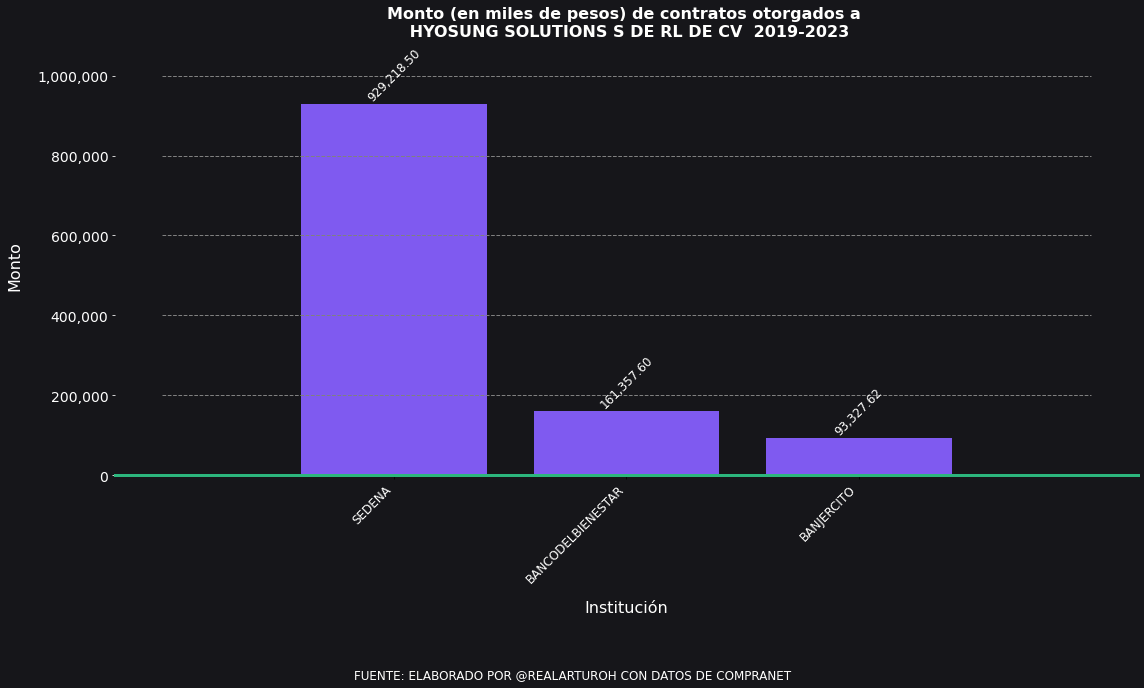

In [103]:
width = max(16, 0.5*len(instituciones))
height = width * (9/16)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.bar(instituciones, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a \n {proveedor}  2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_xlabel("Institución", fontsize=16, labelpad=15, color='#fffffe')
ax.set_ylabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(instituciones))))
ax.set_xticklabels(instituciones, fontsize=12, rotation=45, color='#fffffe', ha="right")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=14, colors='white')

ax.yaxis.set_major_locator(ticker.MultipleLocator(y_interval))
for y in np.arange(0, max(importe)+y_interval, y_interval):
    plt.hlines(y, xmin=-1, xmax=len(instituciones), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('#2cb67d')

for bar in bars:
    yval = bar.get_height()
    formatted_yval = "{:,.2f}".format(yval)
    ax.text(bar.get_x() + bar.get_width()/2, yval+0.1, formatted_yval, ha='center', va='bottom', fontsize=12, color='#fffffe', rotation=45)

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Resultados de búsqueda por proveedor

In [104]:
# Asumiendo que 'buscar' es tu DataFrame original

# Creando el DataFrame prov_df con sumas de importes
prov_df = buscar.groupby(['proveedor_o_contratista', 'rfc']).agg({'importe':'sum'}).reset_index()
prov_df.sort_values(by='importe', ascending=False, inplace=True)

# Añadiendo la columna 'año_constitucion'
def convert_year(two_digit_year):
    if two_digit_year.isdigit():
        year_int = int(two_digit_year)
        if year_int > 23:
            return "19" + two_digit_year
        else:
            return "20" + two_digit_year
    else:
        return "unknown"

prov_df['año_constitucion'] = prov_df['rfc'].apply(lambda x: convert_year(str(x)[3:5]) if len(str(x)) >= 5 else "unknown")

# 1. Crear una tabla dinámica basada en el importe
pivot_df_importe = buscar.pivot_table(index='proveedor_o_contratista', columns='tipo_de_procedimiento', values='importe', aggfunc='sum', fill_value=0)

# 2. Convertir sumas en porcentajes
pivot_df_percentage = pivot_df_importe.divide(pivot_df_importe.sum(axis=1), axis=0) * 100
pivot_df_percentage.reset_index(inplace=True)

# 3. Fusionar con prov_df
prov_df = pd.merge(prov_df, pivot_df_percentage, on='proveedor_o_contratista', how='left')

# Opcional: mostrar el resultado
pd.options.display.float_format = '{:,}'.format

prov_df

,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,LICITACIÓN PÚBLICA
0,HYOSUNG SOLUTIONS S DE RL DE CV,HSO200602PH2,"1,183,903,721.25",2020,21.51232542635274,78.48767457364725


In [92]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

prov_df2 = prov_df
prov_df2.sort_values(by='importe', ascending=True, inplace=True)
prov_df2 = prov_df2.tail(20)

proveedores = prov_df2['proveedor_o_contratista'].values
importe = prov_df2['importe'].values / 1e3  # Convertimos a miles


In [93]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    x_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    x_interval = magnitude
else:
    x_interval = 2 * magnitude


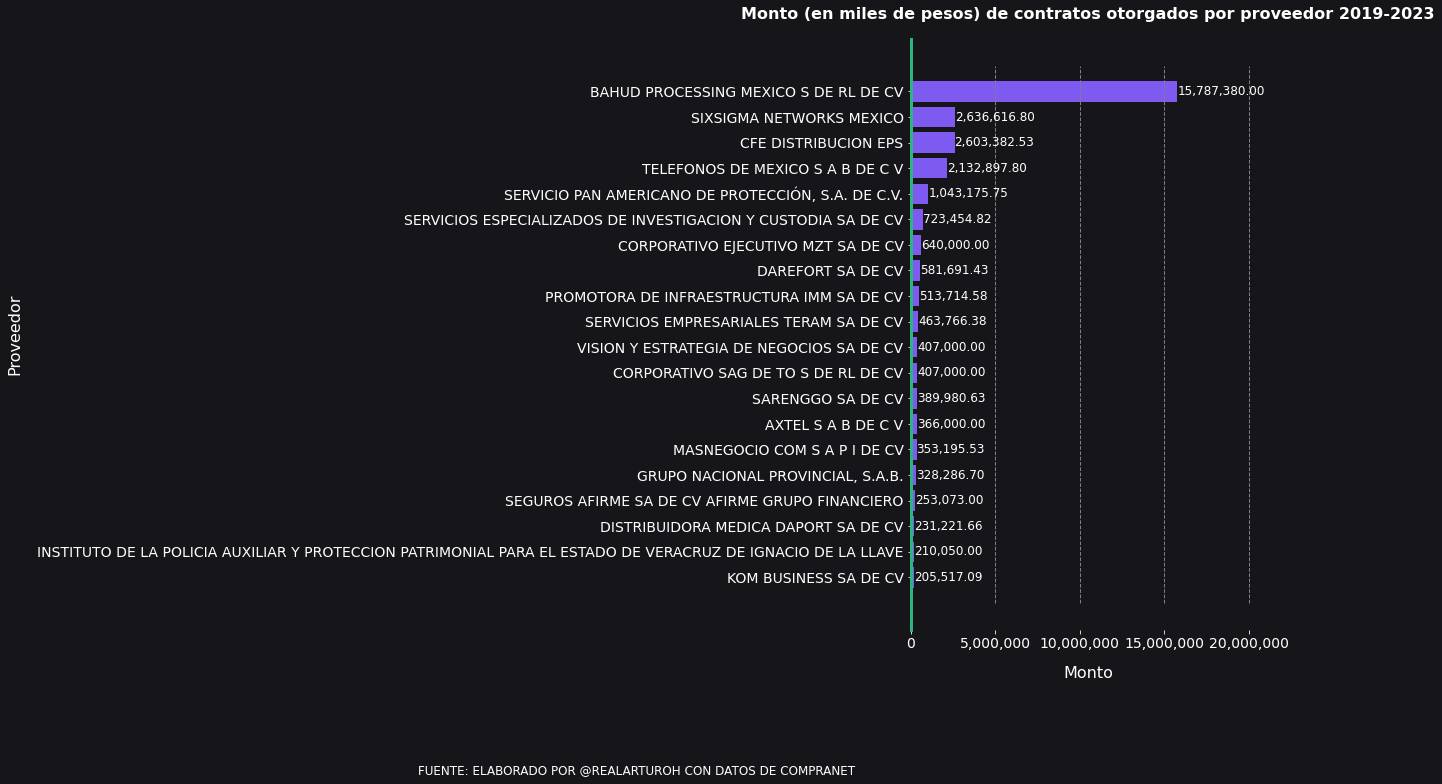

In [94]:
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.barh(proveedores, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados por proveedor 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white')

ax.xaxis.set_major_locator(ticker.MultipleLocator(x_interval))
for x in np.arange(0, max(importe)+x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')

for bar in bars:
    xval = bar.get_width()
    formatted_xval = "{:,.2f}".format(xval)
    ax.text(xval + 0.1, bar.get_y() + bar.get_height()/2, formatted_xval, ha='left', va='center', fontsize=12, color='#fffffe')

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()


### Proveedores sospechosos


In [95]:
import datetime

# Año actual
current_year = datetime.datetime.now().year

# Función para calcular la probabilidad de sospecha
def calculate_suspicion(row):
    suspicion_score = 0

    # Si la empresa se constituyó en los últimos 5 años
    if row['año_constitucion'] != 'unknown' and (current_year - int(row['año_constitucion'])) <= 5:
        suspicion_score += 0.5

    # Si más del 50% de su importe proviene de "ADJUDICACIÓN DIRECTA" o "INVITACIÓN A CUANDO MENOS 3 PERSONAS"
    if row['ADJUDICACIÓN DIRECTA'] + row['INVITACIÓN A CUANDO MENOS 3 PERSONAS'] + row['OTRO'] > 50:
        suspicion_score += 0.5

    return suspicion_score

# Aplicar la función para calcular la probabilidad de sospecha
prov_df['probabilidad_sospecha'] = prov_df.apply(calculate_suspicion, axis=1)

# Filtrar los proveedores sospechosos
suspicious_providers = prov_df[prov_df['probabilidad_sospecha'] == 1]

# Seleccionar los 20 proveedores sospechosos que más han ganado
top_20_suspicious_providers_df = suspicious_providers.nlargest(20, 'importe')

# Resultado
top_20_suspicious_providers_df


,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA,OTRAS CONTRATACIONES,OTRO,probabilidad_sospecha
0,BAHUD PROCESSING MEXICO S DE RL DE CV,BPM1809043P8,"15,787,380,000.0",2018,100.0,0.0,0.0,0.0,0.0,0.0,1.0
11,CORPORATIVO SAG DE TO S DE RL DE CV,CST190326II7,"407,000,000.0",2019,100.0,0.0,0.0,0.0,0.0,0.0,1.0
24,HYOSUNG SOLUTIONS S DE RL DE CV,HSO200602PH2,"161,357,600.0",2020,100.0,0.0,0.0,0.0,0.0,0.0,1.0
73,INGENIERIA Y CONSTRUCCION KRISHINA SA DE CV,ICK180323P28,"7,852,450.77",2018,0.0,0.0,100.0,0.0,0.0,0.0,1.0
130,GLOBAL COMERCIALIZADORA JAMIJ SA DE CV,GCJ200521HX1,"922,399.0",2020,100.0,0.0,0.0,0.0,0.0,0.0,1.0
140,INDICE DOVER SA DE CV,IDO1804036JA,"689,655.17",2018,100.0,0.0,0.0,0.0,0.0,0.0,1.0
144,PRESIDENTE DIGITAL SA DE CV,PDI1906138X0,"675,000.0",2019,100.0,0.0,0.0,0.0,0.0,0.0,1.0
156,IMPRENTA IDEIM SA DE CV,IID190529NF6,"560,000.0",2019,100.0,0.0,0.0,0.0,0.0,0.0,1.0
165,DAFAR SERVICIOS S DE RL DE CV,DSE201208LU8,"500,000.0",2020,100.0,0.0,0.0,0.0,0.0,0.0,1.0
166,OPERADORA MFG - OPERADORA DE MULTISERVICIOS FO...,OMG1905254A8,"498,000.0",2019,100.0,0.0,0.0,0.0,0.0,0.0,1.0


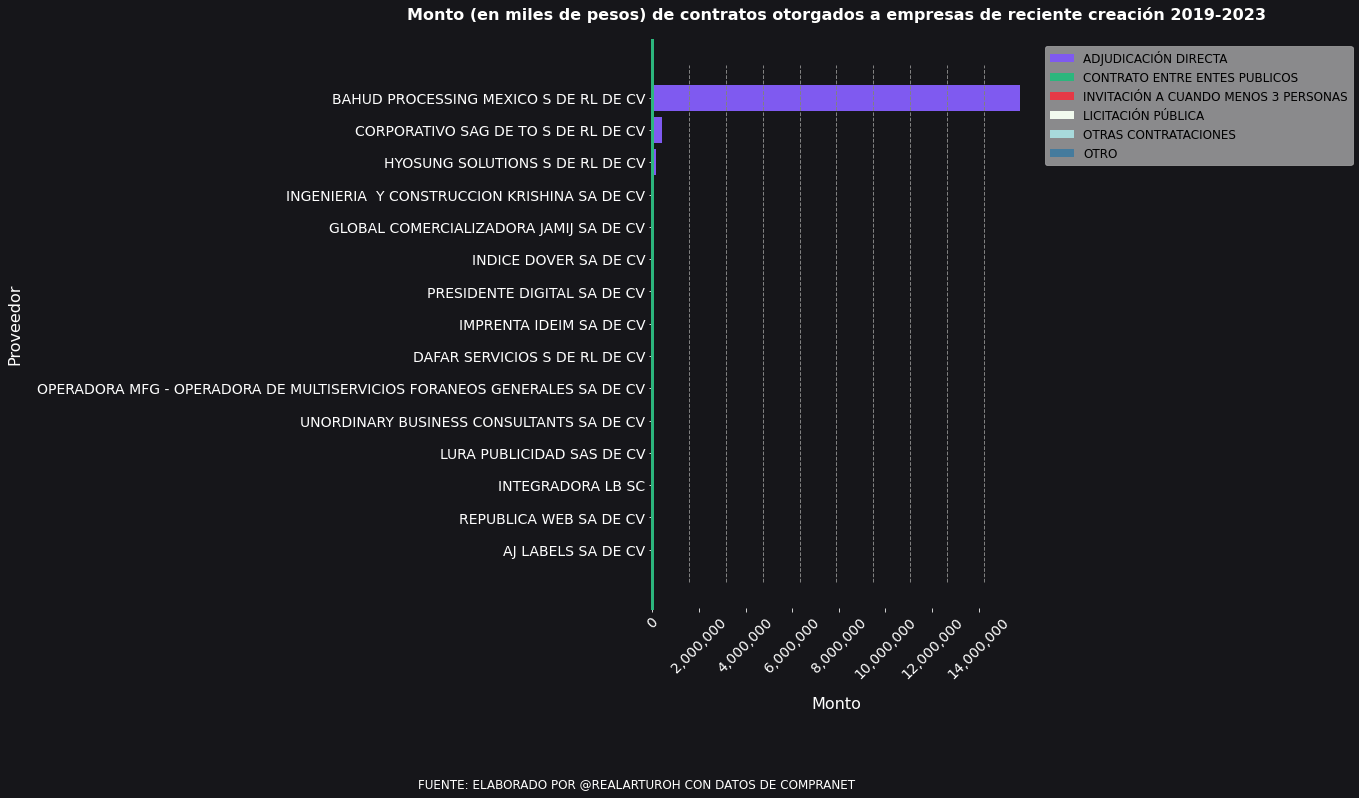

In [96]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

top20df = top_20_suspicious_providers_df.sort_values(by='importe', ascending=True)
top20df['importe'] = top20df['importe']/1000

# Datos
proveedores = top20df['proveedor_o_contratista'].tolist()
tipos_procedimiento = ['ADJUDICACIÓN DIRECTA', 'CONTRATO ENTRE ENTES PUBLICOS', 'INVITACIÓN A CUANDO MENOS 3 PERSONAS', 'LICITACIÓN PÚBLICA', 'OTRAS CONTRATACIONES', 'OTRO']

# Calcular los importes por tipo de procedimiento en función de los porcentajes y el importe total
data_procedimientos = []
for tipo in tipos_procedimiento:
    importe_tipo = (top20df[tipo] / 100) * top20df['importe']
    data_procedimientos.append(importe_tipo.values)

# Colores
colors = ['#7f5af0', '#2cb67d', '#e63946', '#f1faee', '#a8dadc', '#457b9d']

# Tamaño de la figura
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))

# Generar las barras apiladas
bars = []
for i, data in enumerate(data_procedimientos):
    bars.append(ax.barh(proveedores, data, left=[sum(data_procedimientos[j][k] for j in range(i)) for k in range(len(data))], color=colors[i % len(colors)]))

# Configuración del gráfico
ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a empresas de reciente creación 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white', rotation=45)
x_interval = (top20df['importe'].max() / 10)
for x in np.arange(0, top20df['importe'].max() + x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)
fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')
for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')
legend = ax.legend(bars, tipos_procedimiento, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
frame = legend.get_frame()
frame.set_alpha(0.5)
plt.figtext(0.5, -0.1, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, right=0.8)
plt.show()
